In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../../SpikePy")
import SpikePy as sp
import matplotlib.pyplot as plt
import pandas as pd
from fastai.tabular import * 
from torch.nn.functional import softmax

In [18]:
def predict(df, learn, numeric, categs):
    x_cat, x_num = get_x_cat_num(df, numeric, categs, mean, std)
    return softmax(learn.model(x_cat, x_num), dim=1).detach().numpy()

def get_x_cat_num(df, numeric, categs, mean, std):
    x_num = (torch.Tensor(df[numeric].values) - mean)/std
    df_categs = df[categs].astype('category')
    x_cat = []
    for _, col in df_categs.iteritems():
        x_cat += [col.cat.codes.values + 1] #le sumo 1 por el embeding de #nan#
    x_cat = torch.LongTensor(np.array(x_cat).T)
    return x_cat, x_num

# Cargar datos
https://www.kaggle.com/wenruliu/adult-income-dataset/

In [3]:
df = pd.read_csv('adult.csv')
df.head()

age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

In [4]:
numeric = list(df.dtypes[df.dtypes == 'int64'].index)
numeric.sort()
target = 'income'
categs = [x for x in df.dtypes[df.dtypes == 'object'].index if x != target]

# Histogramas variables númericas

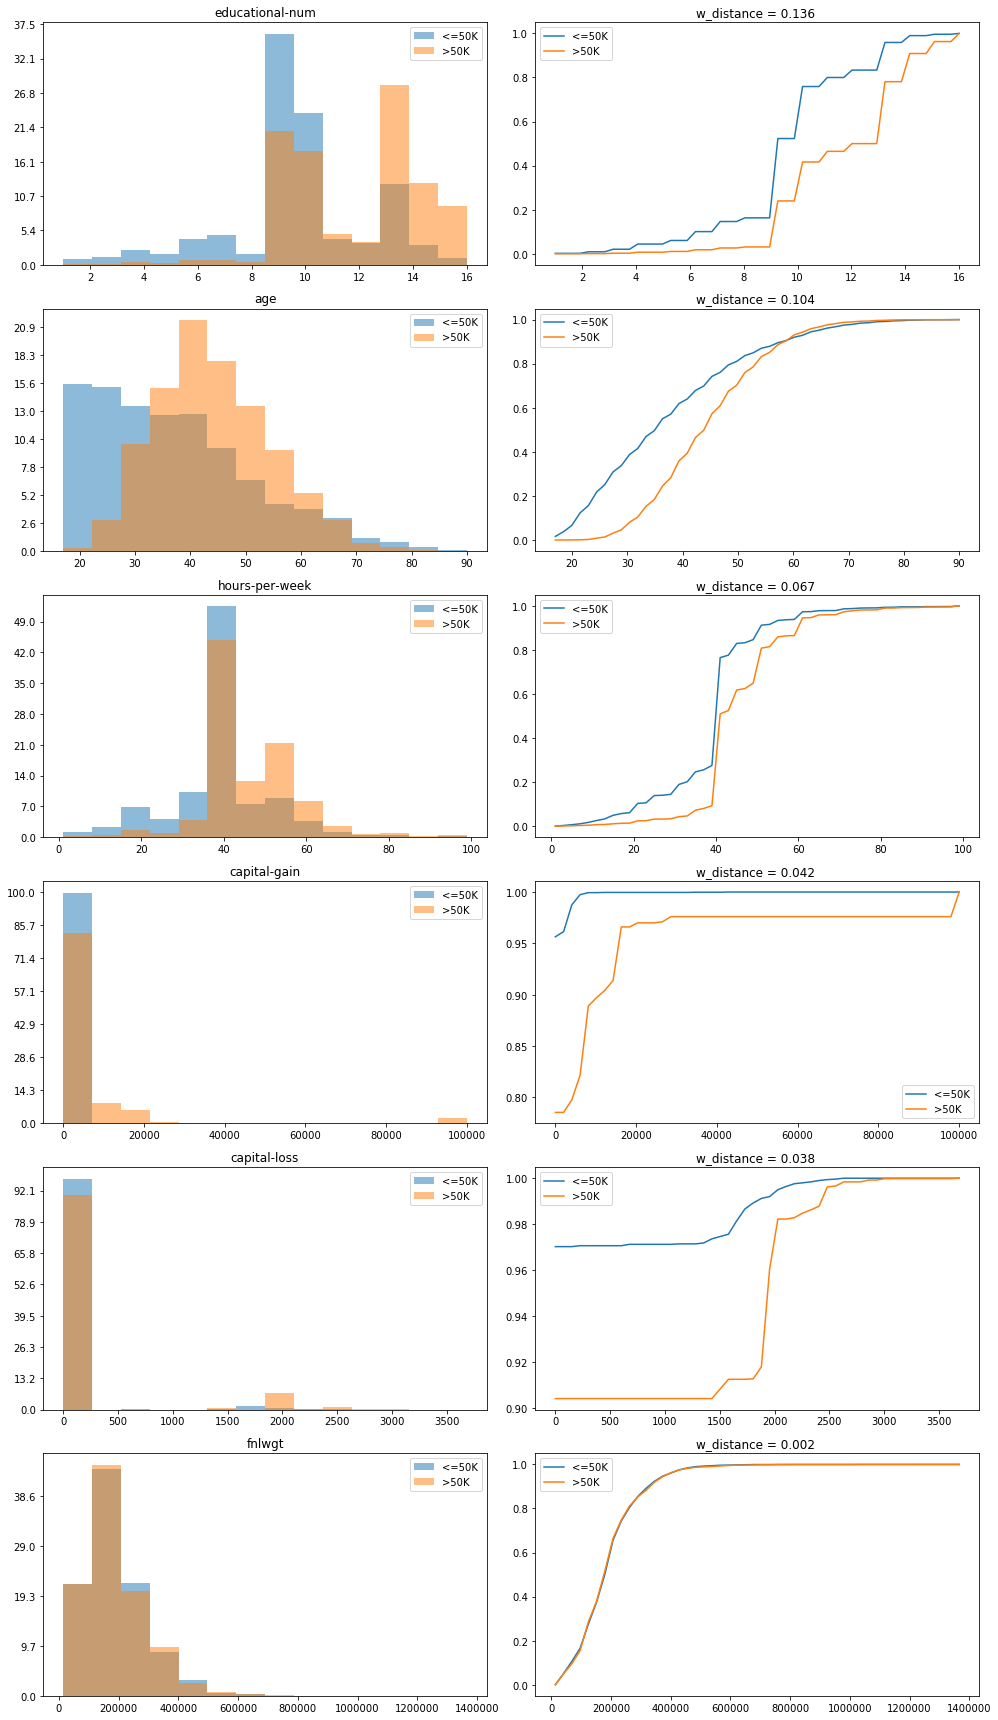

In [5]:
sp.compare_cont_dists([df], numeric, groupby=target, nbins=15);

# PDP variables númericas
pdp en este caso es la probabilidad condicional, es decir, para cada variable $Z$ (númerica o categorica) se plotea la función $x \mapsto \mathbb{P}(\text{ganar } > 50K |  Z = x)$


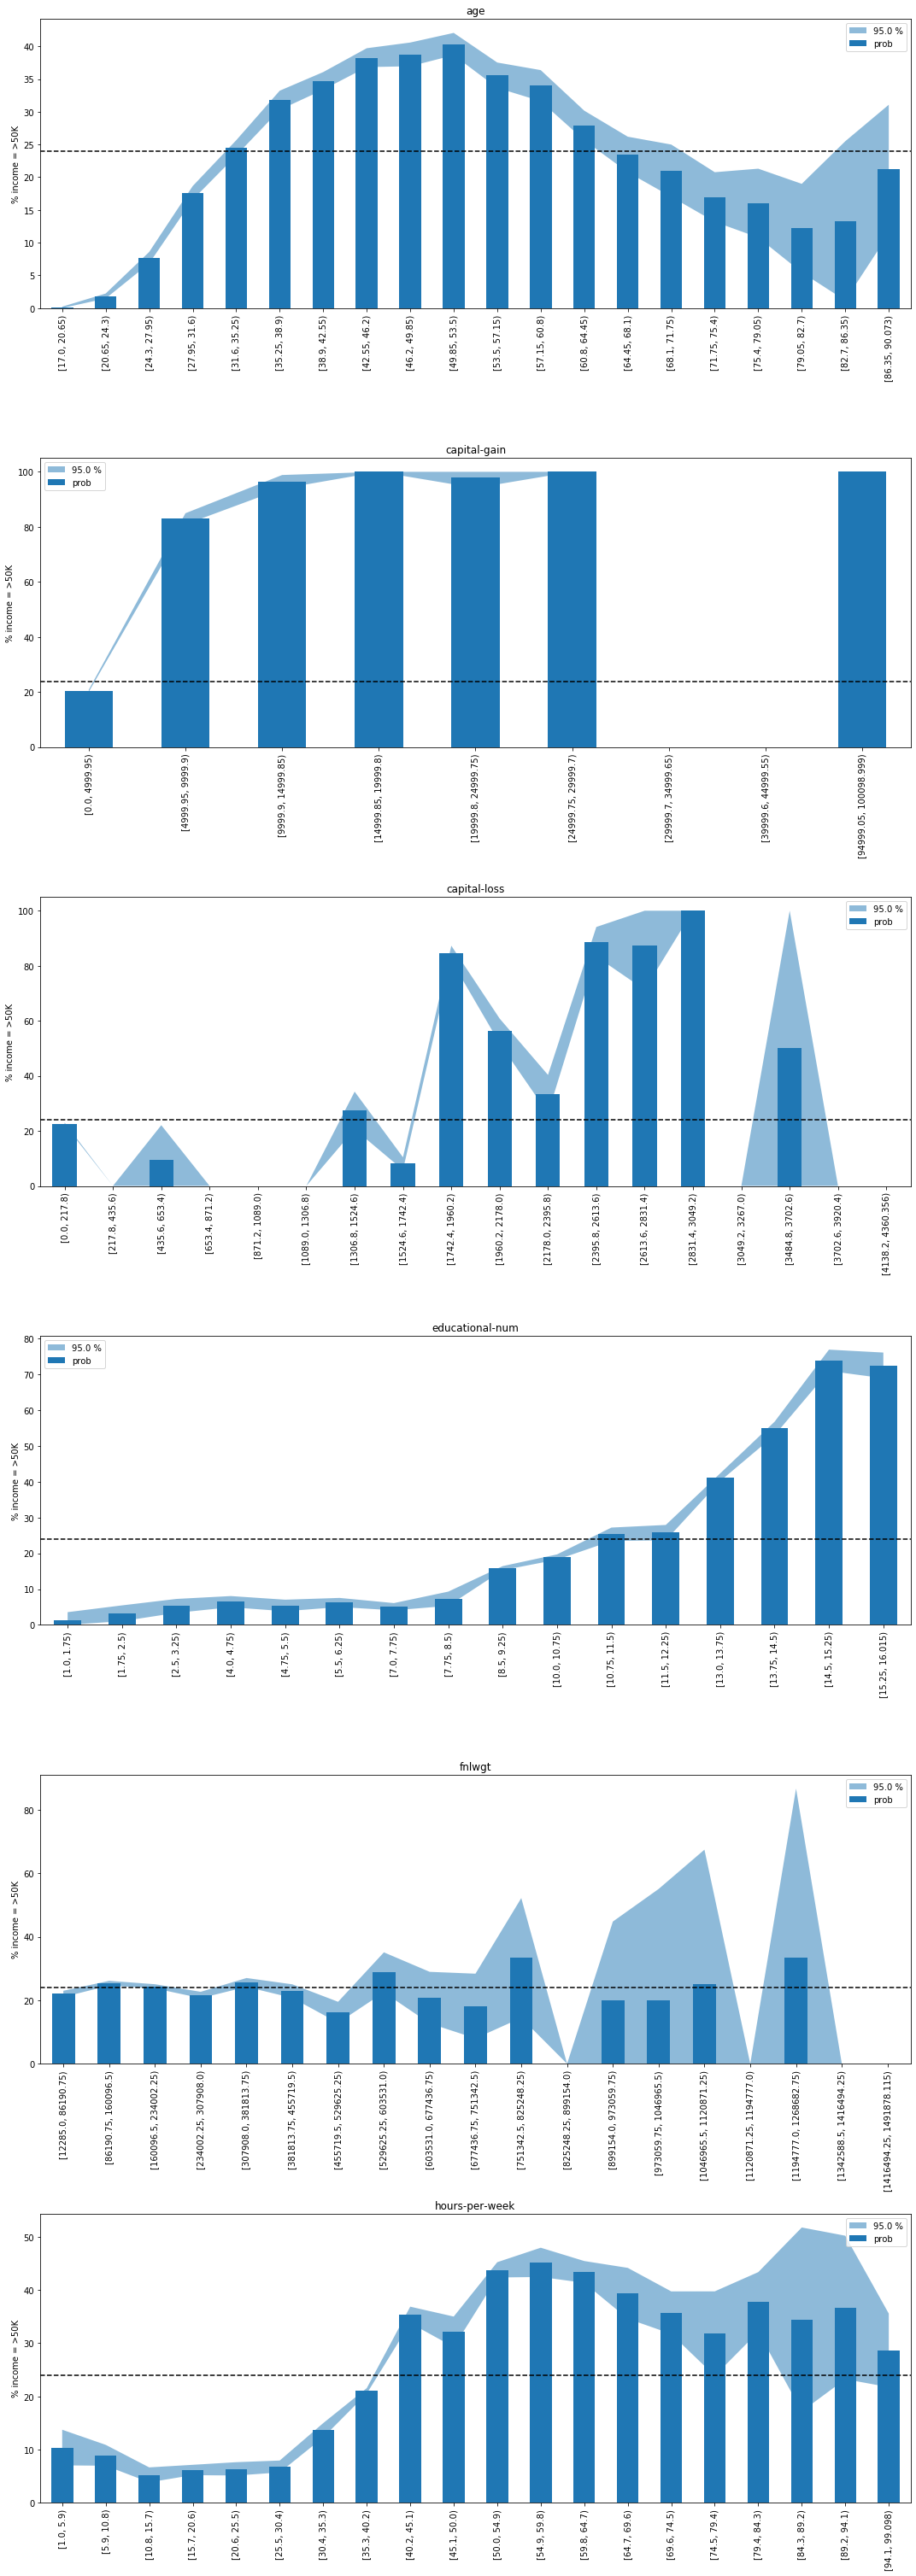

In [6]:
sp.pdplot(df, numeric, target, numeric=True, pos_class='>50K', nbins=20);

# PDP variables categóricas

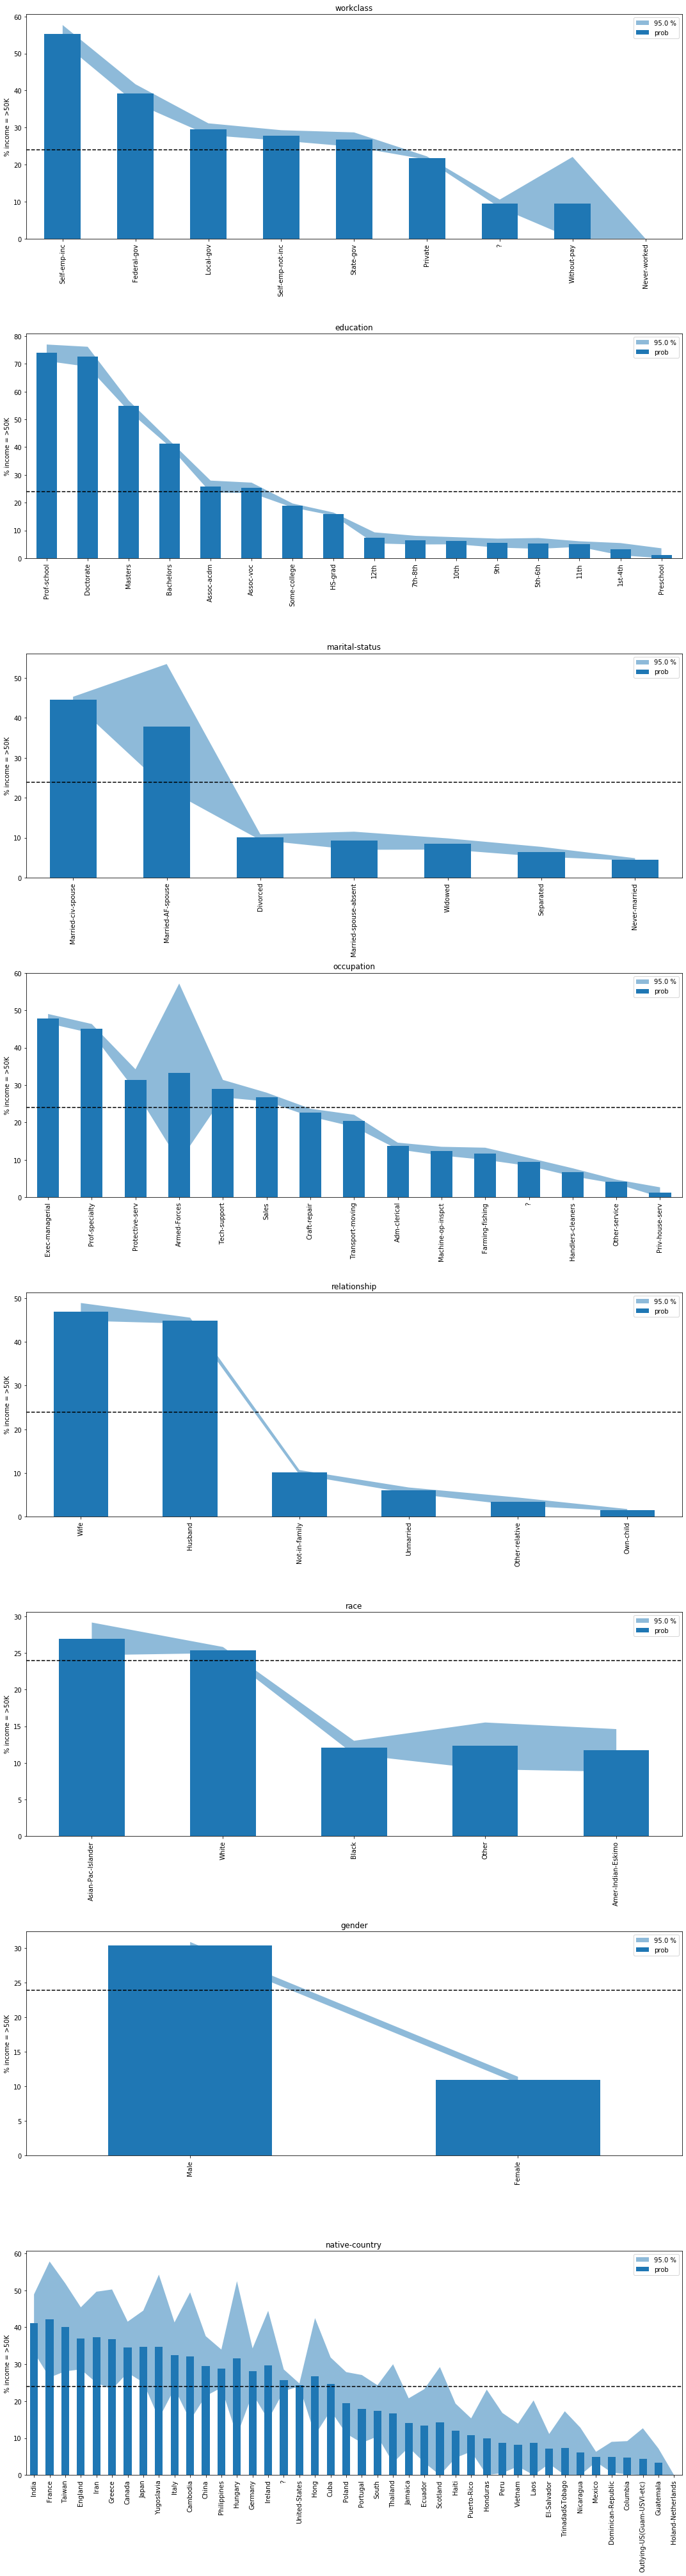

In [7]:
sp.pdplot(df, categs, target, numeric=False, pos_class='>50K');

# Modelos

In [8]:
mean_prob_gender = {}
distance_prob_gender = {}
mean_prob_race = {}

## Todas las vars

In [9]:
version = 'todas_las_vars'

In [10]:
procs = [FillMissing, Categorify, Normalize]
path = '.'

In [11]:
df.head()

age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

In [12]:
data = (TabularList.from_df(df, 
                            path=path, cat_names=categs, cont_names=numeric, procs=procs)
                           .split_by_rand_pct(valid_pct=0.1, seed=1313)
                           .label_from_df(cols=target)
                           .databunch())

In [13]:
mean = torch.Tensor(df[numeric].mean().values)
std = torch.Tensor(df[numeric].std().values)

In [14]:
learn = tabular_learner(data, layers=[20, 5], emb_drop=0.1, metrics=[accuracy], callback_fns=[ShowGraph])
learn.summary() 

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [6]                  60         True      
______________________________________________________________________
Embedding            [8]                  136        True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [8]                  128        True      
______________________________________________________________________
Embedding            [5]                  35         True      
______________________________________________________________________
Embedding            [4]                  24         True      
______________________________________________________________________
Embedding            [3]                  9          True      
_________________________________________________

### Entrenar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


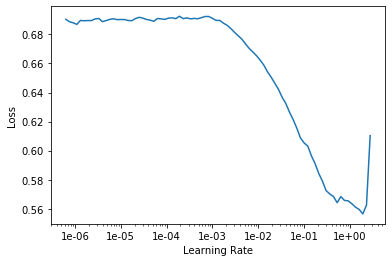

In [15]:
learn.lr_find()
learn.recorder.plot()

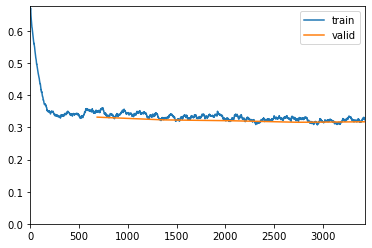

In [16]:
learn.fit_one_cycle(5, 5e-2)  

### Fairness

In [19]:
probs = predict(df, learn, numeric, categs)
df['prob>50K'] = probs[:, 1]

In [20]:
df.groupby('gender')['prob>50K'].mean()

gender
Female    0.101248
Male      0.293647
Name: prob>50K, dtype: float32

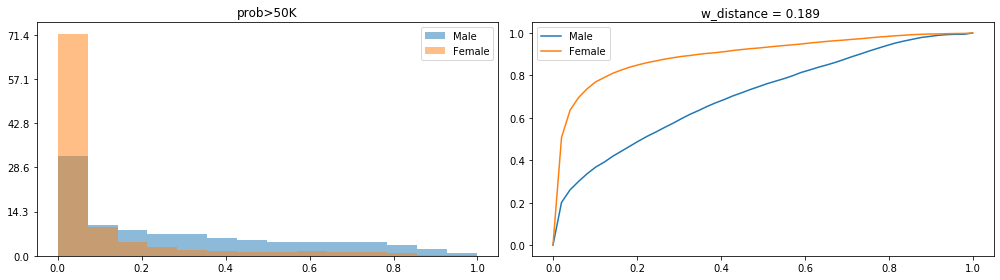

In [21]:
fig, axes, dist = sp.compare_cont_dists([df], ['prob>50K'], groupby='gender', 
                                        nbins=15, nsample=10000, plot_cdf=True);

In [22]:
mean_prob_gender[version] = df.groupby('gender')['prob>50K'].mean()
mean_prob_race[version] = df.groupby('race')['prob>50K'].mean()
distance_prob_gender[version] = dist.values.flatten()

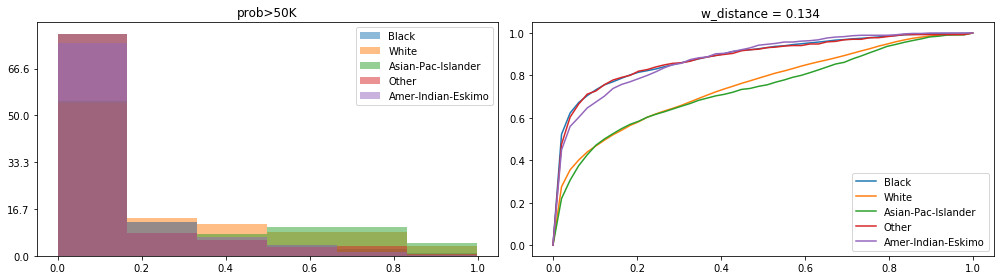

In [23]:
sp.compare_cont_dists([df], ['prob>50K'], groupby='race', nbins=7,  
                      nsample=10000, plot_cdf=True);

## Sin gender ni race

In [24]:
version = 'sin_gender_race'
categs_ = [c for c in categs if c not in ['gender', 'race']]

In [25]:
procs = [FillMissing, Categorify, Normalize]
path = '.'

In [26]:
df.head()

age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  prob>50K  
0              40  United-States  <=50K  0.003035  
1              50  United-States  <=50K  0.163714  
2              40  United-States   >50K  0.353698  
3              40  United-States   >50K  0.483382  
4              30  United-States  <=50K  0.000565

In [27]:
data = (TabularList.from_df(df, 
                            path=path, cat_names=categs_, cont_names=numeric, procs=procs)
                           .split_by_rand_pct(valid_pct=0.1, seed=1313)
                           .label_from_df(cols=target)
                           .databunch())

In [28]:
mean = torch.Tensor(df[numeric].mean().values)
std = torch.Tensor(df[numeric].std().values)

In [29]:
learn = tabular_learner(data, layers=[20, 5], emb_drop=0.1, metrics=[accuracy], callback_fns=[ShowGraph])
learn.summary() 

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [6]                  60         True      
______________________________________________________________________
Embedding            [8]                  136        True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [8]                  128        True      
______________________________________________________________________
Embedding            [5]                  35         True      
______________________________________________________________________
Embedding            [13]                 559        True      
______________________________________________________________________
Dropout              [45]                 0          False     
_________________________________________________

### Entrenar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


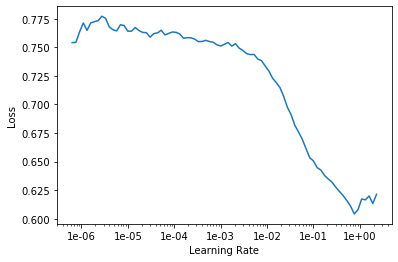

In [30]:
learn.lr_find()
learn.recorder.plot()

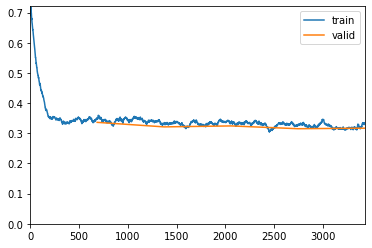

In [31]:
learn.fit_one_cycle(5, 5e-2)  

### Fairness

In [32]:
probs = predict(df, learn, numeric, categs)
df['prob>50K'] = probs[:, 1]

In [33]:
df.groupby('gender')['prob>50K'].mean()

gender
Female    0.044864
Male      0.100294
Name: prob>50K, dtype: float32

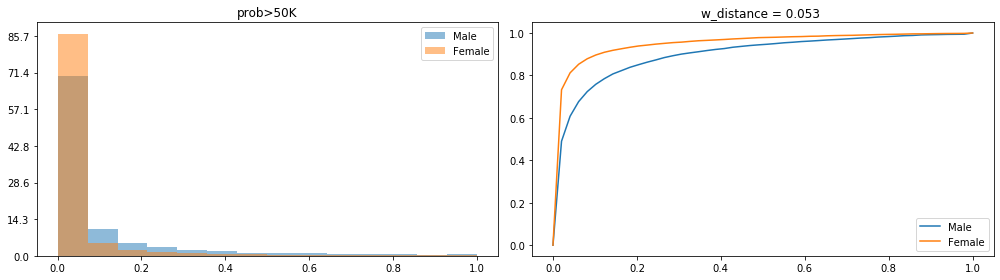

In [34]:
fig, axes, dist = sp.compare_cont_dists([df], ['prob>50K'], groupby='gender', 
                                        nbins=15, nsample=10000, plot_cdf=True);

In [35]:
mean_prob_gender[version] = df.groupby('gender')['prob>50K'].mean()
mean_prob_race[version] = df.groupby('race')['prob>50K'].mean()
distance_prob_gender[version] = dist.values.flatten()

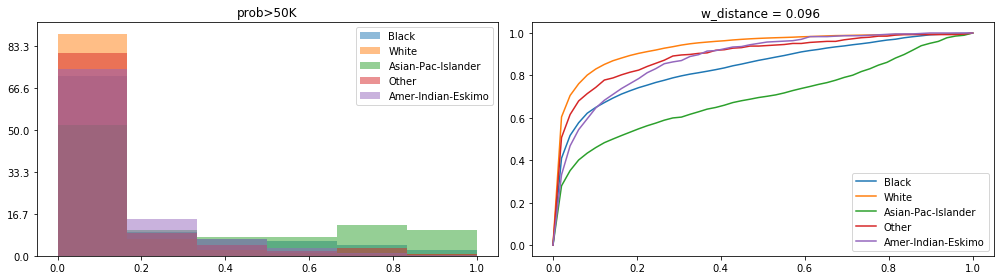

In [36]:
sp.compare_cont_dists([df], ['prob>50K'], groupby='race', nbins=7,  
                      nsample=10000, plot_cdf=True);

In [37]:
pd.DataFrame(mean_prob_gender)

todas_las_vars  sin_gender_race
gender                                 
Female        0.101248         0.044864
Male          0.293647         0.100294

In [38]:
pd.DataFrame(distance_prob_gender)

todas_las_vars sin_gender_race
0       0.189289        0.053244

In [39]:
pd.DataFrame(mean_prob_race)

todas_las_vars  sin_gender_race
race                                               
Amer-Indian-Eskimo        0.118630         0.121463
Asian-Pac-Islander        0.264952         0.305589
Black                     0.112784         0.161319
Other                     0.115997         0.104026
White                     0.244081         0.064215

## Regularizado

In [40]:
version = 'regularizado'

In [41]:
procs = [FillMissing, Categorify, Normalize]
path = '.'

In [42]:
df.head()

age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  prob>50K  
0              40  United-States  <=50K  0.002397  
1              50  United-States  <=50K  0.009989  
2              40  United-States   >50K  0.020270  
3              40  United-States   >50K  0.650083  
4              30  United-States  <=50K  0.000661

In [43]:
data = (TabularList.from_df(df, 
                            path=path, cat_names=categs, cont_names=numeric, procs=procs)
                           .split_by_rand_pct(valid_pct=0.1, seed=1313)
                           .label_from_df(cols=target)
                           .databunch())

In [44]:
mean = torch.Tensor(df[numeric].mean().values)
std = torch.Tensor(df[numeric].std().values)

In [45]:
learn = tabular_learner(data, layers=[20, 5], emb_drop=0.1, metrics=[accuracy], callback_fns=[ShowGraph])
learn.summary() 

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [6]                  60         True      
______________________________________________________________________
Embedding            [8]                  136        True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [8]                  128        True      
______________________________________________________________________
Embedding            [5]                  35         True      
______________________________________________________________________
Embedding            [4]                  24         True      
______________________________________________________________________
Embedding            [3]                  9          True      
_________________________________________________

### Entrenar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


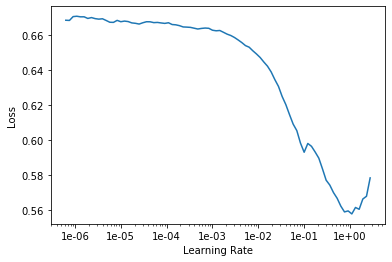

In [46]:
learn.lr_find()
learn.recorder.plot()

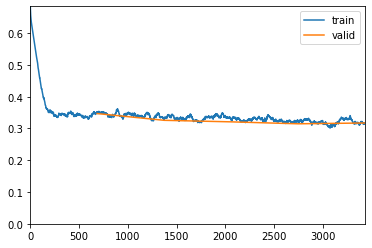

In [47]:
learn.fit_one_cycle(5, 5e-2)  

### Modelo bayesiano con regularizacion

In [93]:
import pyro
import pyro.distributions as dist
from pyro import poutine

from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, TracePredictive
from pyro.optim import Adam
from pyro.infer import EmpiricalMarginal

In [105]:
y = torch.Tensor(df[target].astype('category').cat.codes)
x_cat, x_num = get_x_cat_num(df, numeric, categs, mean, std)

In [72]:
x_num.shape, x_cat.shape, y.shape

(torch.Size([48842, 6]), torch.Size([48842, 8]), torch.Size([48842]))

In [107]:
males = torch.LongTensor(df['gender'].values == 'Male')
females = torch.LongTensor(df['gender'].values == 'Female')
lmbd = 1000

def model(x_cat, x_num, y):
    
    #genero prios centrados en valores entrenados por fastai y 
    priors = {}
    for name, values in learn.model.named_parameters():
        priors[name] = dist.Normal(loc=values, 
                                   scale= 0.01 * torch.ones_like(values))
    
    lifted_module = pyro.random_module("module",  learn.model, priors)
    lifted_module_sample = lifted_module()
    
    pred = softmax(lifted_module_sample(x_cat, x_num))[:, 1] #probabilidad clase 1
    pred_dummy = pyro.sample('pred', dist.Delta(pred), obs=pred)
    
    #likelihood:
    pyro.sample('obs', dist.Bernoulli(pred), obs=y)
    
    #regularizcion
    mean_pred_males = pred[males].mean()
    mean_pred_females = pred[females].mean()
    unfairness = torch.pow(mean_pred_males - mean_pred_females, 2)
    
    pyro.sample('regular', dist.Normal(loc=torch.zeros(1, ), scale=1/lmbd), 
                obs=unfairness)
    return pred

In [110]:
guide = AutoDiagonalNormal(model)

In [111]:
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [112]:
pyro.clear_param_store()
num_iterations = 500
loss_list = []

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_cat, x_num, y)
    loss_list += [loss]
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss))

/Users/camiloiturracisternas/miniconda3/envs/spike_basicoV5/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


[iteration 0001] loss: 130518.9487


KeyboardInterrupt: 

### Fairness

In [17]:
probs = predict(df, learn, numeric, categs)
df['prob>50K'] = probs[:, 1]

In [18]:
df.groupby('gender')['prob>50K'].mean()

gender
Female    0.112628
Male      0.304276
Name: prob>50K, dtype: float32

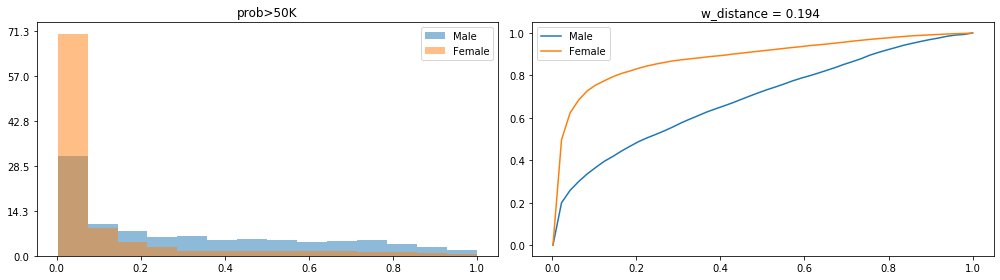

In [46]:
fig, axes, dist = sp.compare_cont_dists([df], ['prob>50K'], groupby='gender', 
                                        nbins=15, nsample=10000, plot_cdf=True);

In [50]:
mean_prob_gender[version] = df.groupby('gender')['prob>50K'].mean()
mean_prob_race[version] = df.groupby('race')['prob>50K'].mean()
distance_prob_gender[version] = dist.values.flatten()

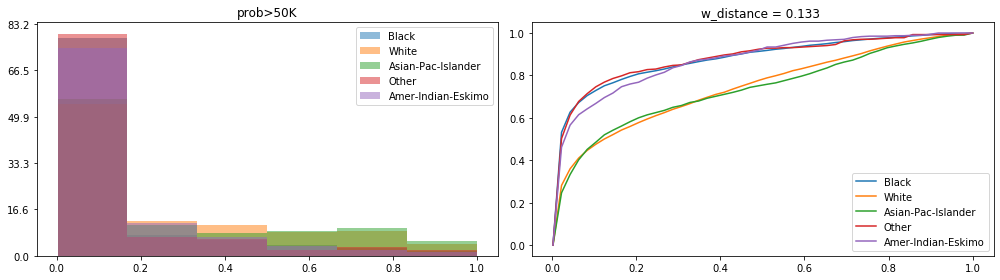

In [51]:
sp.compare_cont_dists([df], ['prob>50K'], groupby='race', nbins=7,  
                      nsample=10000, plot_cdf=True);